In [1]:
!pip install mahotas

     |████████████████████████████████| 5.7MB 2.6MB/s 


In [1]:
%tensorflow_version 1.x
import tensorflow as tf
import cv2
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.layers.normalization import BatchNormalization
from keras.applications.mobilenet_v2 import MobileNetV2
from keras import regularizers
import cv2
import mahotas

TensorFlow 1.x selected.


Using TensorFlow backend.


In [16]:
#-----------------------------------
# GLOBAL FEATURE EXTRACTION
#-----------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py


In [ ]:
base_dir='/content/drive/My Drive/data/trainning/'
train_dir=os.path.join(base_dir,'train/')
validation_dir=os.path.join(base_dir,'validation/')
train_up_dir=os.path.join(train_dir,'up')
train_down_dir=os.path.join(train_dir,'down')
train_right_dir=os.path.join(train_dir,'right')
train_left_dir=os.path.join(train_dir,'left')

validation_up_dir=os.path.join(validation_dir,'up')
validation_down_dir=os.path.join(validation_dir,'down')
validation_right_dir=os.path.join(validation_dir,'right')
validation_left_dir=os.path.join(validation_dir,'left')

In [ ]:
num_up_tr=len(os.listdir(train_up_dir))
num_down_tr=len(os.listdir(train_down_dir))
num_right_tr=len(os.listdir(train_right_dir))
num_left_tr=len(os.listdir(train_left_dir))

num_up_val=len(os.listdir(validation_up_dir))
num_down_val=len(os.listdir(validation_down_dir))
num_right_val=len(os.listdir(validation_right_dir))
num_left_val=len(os.listdir(validation_left_dir))

In [ ]:
total_train=num_up_tr+num_down_tr+num_right_tr+num_left_tr
total_val=num_up_val+num_down_val+num_right_val+num_left_val

In [ ]:
print("Total train: ",total_train)
print("Total validation : ",total_val)

In [17]:
def fd_histogram(image, mask=None):
    # chuyển về không gian màu HSV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize histogram
    cv2.normalize(hist, hist)
    return hist.flatten()

In [18]:
def fd_hu_moments(image):
    # chuyển về ảnh gray
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [19]:
def fd_haralick(image):
    # chuyển về ảnh gray
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

In [20]:
output_path = "/content/drive/My Drive/data/output"

# path to training data
train_path = "/content/drive/My Drive/data/trainning/train"

# get the training labels
train_labels = os.listdir(train_path)
train_labels.sort()
print(train_labels)

# num of images per class
images_per_class = 900

# fixed-sizes for image
fixed_size = tuple((720,1280))

# bins for histogram
bins = 8

# empty lists to hold feature vectors and labels
global_features = []
labels = []


['down', 'left', 'right', 'up']


In [ ]:
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)
     # get the current training label
    current_label = training_name
    x=os.listdir(dir)
    x=np.array(x)
    x.reshape(1,-1)
    for i in x:
      file=os.path.join(dir,i)
      print(file)
      image = cv2.imread(file)
       # Global Feature extraction
      fv_hu_moments = fd_hu_moments(image)
      fv_haralick   = fd_haralick(image)
      fv_histogram  = fd_histogram(image)
      ###################################
        # Concatenate global features
        ###################################
      global_feature = np.hstack([fv_histogram, fv_hu_moments, fv_haralick])
      # update the list of labels and feature vectors
      labels.append(current_label)
      global_features.append(global_feature)
    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")


# get the overall feature vector size
print ("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print ("[STATUS] training Labels {}".format(np.array(labels).shape))

# encode the target labels
le = LabelEncoder()
target = le.fit_transform(labels)

# normalize the feature vector in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)

# save the feature vector using HDF5
h5f_data = h5py.File(output_path+'data.h5', 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File(output_path+'labels.h5', 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print("[STATUS] end of training..")

In [22]:

#-----------------------------------
# TRAINING OUR MODEL
#-----------------------------------
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

warnings.filterwarnings('ignore')


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [23]:
# path to output
output_path = "/content/drive/My Drive/data/output"

# fixed-sizes for image
fixed_size = tuple((720, 1280))

# no.of.trees for Random Forests
num_trees = 300
# bins for histogram
bins = 8

# num of images per class
images_per_class = 900;

# import the feature vector and trained labels
h5f_data = h5py.File(output_path+'data.h5', 'r')
h5f_label = h5py.File(output_path+'labels.h5', 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

In [28]:
# create all the machine learning models
seed=9
# no.of.trees for Random Forests
num_trees = 300
scoring    = "accuracy"
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (3600, 532)
[STATUS] labels shape: (3600,)
[STATUS] training started...


LR: 0.865278 (0.143277)
LDA: 0.907778 (0.092194)
KNN: 0.797778 (0.169876)
CART: 0.716667 (0.195414)
RF: 0.798056 (0.192390)
NB: 0.751389 (0.200113)
SVM: 0.855556 (0.131914)


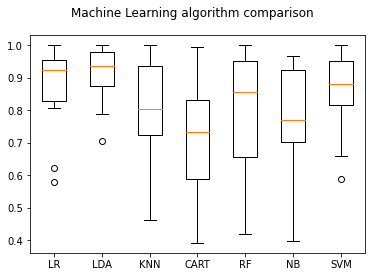

In [29]:
# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, global_features,global_labels, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()


In [30]:
clf  = LinearDiscriminantAnalysis()
clf.fit(global_features, global_labels)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [36]:
# save the model to disk
import pickle
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
# path to test data
test_path = "/content/drive/My Drive/data/test"
# get the training labels
test_labels = os.listdir(test_path)
global_features_test=[]
# sort the training labels
test_labels.sort()
print(test_labels)
# loop through the test images
test_features = []
test_results = []
for testing_name in test_labels:
    # join the training data path and each species training folder
    dir = os.path.join(test_path, testing_name)

    # get the current training label
    current_label = testing_name
    # loop over the images in each sub-folder
    x=os.listdir(dir)
    x=np.array(x)
    x.reshape(1,-1)
    for i in x:
        file=os.path.join(dir,i)
        # print(file)
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)
        ####################################
        fv_hu_moments = fd_hu_moments(image)
        fv_haralick   = fd_haralick(image)
        fv_histogram  = fd_histogram(image)

        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        # scale features in the range (0-1)
        scaler = MinMaxScaler(feature_range=(0, 1))
        global_feature=global_feature.reshape(1,-1)
        rescaled_feature = scaler.fit_transform(global_feature)

        # predict label of test image
        prediction = clf.predict(rescaled_feature.reshape(1,-1))[0]

        # show predicted label on image
        cv2.putText(image, train_labels[prediction], (40,50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

        # display the output image
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()
print ("[STATUS] feature vector size {}".format(np.array(global_features).shape))
# # predict label of test image
# le = LabelEncoder()
# y_result = le.fit_transform(test_results)
# y_pred = clf.predict(test_features)
# print(y_pred)
# print("Result: ", (y_pred == y_result).tolist().count(True)/len(y_result))

In [ ]:
BATCH_SIZE=100
EPOCHS=50
IMG_SHAPEX=720
IMG_SHAPEY=1280


In [ ]:
image_gen_train=ImageDataGenerator(rescale=1./255)
train_data_gen=image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                   directory=train_dir,
                                                   shuffle=True,
                                                   target_size=(IMG_SHAPEX,IMG_SHAPEY))

In [ ]:
image_gen_val=ImageDataGenerator(rescale=1./255)
val_data_gen=image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                   directory=validation_dir,
                                                   target_size=(IMG_SHAPEX,IMG_SHAPEY))

In [ ]:
model = Sequential()
model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(IMG_SHAPEX, IMG_SHAPEY, 3)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))


In [ ]:
model.compile(loss='sparse_categorical_crossentropy'
    , optimizer='adam'
    , metrics=['accuracy']
)

In [ ]:
model.summary()

In [ ]:
history = model.fit_generator(train_data_gen, epochs=EPOCHS,
                    steps_per_epoch=total_train//BATCH_SIZE,
                    validation_data=val_data_gen,
                    validation_steps=total_val//BATCH_SIZE
                    )

In [ ]:
!pip install -q --upgrade ipython
!pip install -q --upgrade ipykernel

In [ ]:
!pip install -q --upgrade ipython==5.5.0
!pip install -q --upgrade ipykernel==4.6.0

In [ ]:
!python -m pip install tensorflow-gpu==1.15

!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!apt-get install cuda=9.0.176-1

In [ ]:
!cat /var/log/colab-jupyter.log

In [5]:


class SimpleDatasetLoader:
    def __init__(self, preprocessors=None):
        # store the image preprocessor
        self.preprocessors = preprocessors

        # if preprocessors are None, initialize them as an empty list
        if self.preprocessors is None:
            self.preprocessors = []
        
    def load(self, imagePaths, verbose=-1):
        # initialize the list of features and labels
        data = []
        labels = []

        # loop over the input images
        for (i, imagePath) in enumerate(imagePaths):
            # load the image and extract the class labels 
            # format: /path/to/dataset/{class label}/{image}.jpg
            image = cv2.imread(imagePath)
            label = imagePath.split(os.path.sep)[-2]
            
            # check to see if preprocessors are not None
            if self.preprocessors is not None:
                # loop over the preprocessors and apply each to image
                for p in self.preprocessors:
                    image = p.preprocess(image)
            
            # upadate the data list followed by the labels
            data.append(image)
            labels.append(label)

            # show an update every 'verbose' image on screen
            if verbose > 0 and i > 0 and (i+1)%verbose == 0:
                print("[INFO] processed {}/{}".format(i + 1, len(imagePaths)))

        # return a tuple of the data and labels
        return (np.array(data), np.array(labels))

In [ ]:
imagePaths = list(paths.list_images("Dataset Leaf"))